In [6]:
import pandas as pd
import numpy as np

# path to the CSV you wrote after imputation
df = pd.read_csv("../data/processed/eda_after_imputation.csv", low_memory=False)

# peek
print(df.shape)
df.head(2)

(7917, 140)


,Título,Num_Drives,Disco duro_Capacidad de memoria SSD,Pantalla_Displayglas_flag,Gráfica_GPU_flag,Pantalla_Tecnología de la pantalla_flag,Conectividad_Lector de tarjetas_flag,Cámara_Webcam_flag,Precio_min,Precio_max,...,GPU_AMD_Radeon_RX,GPU_Apple_GPU,GPU_Intel_Arc,GPU_Intel_Integrated,GPU_NVIDIA_GeForce_GTX,GPU_NVIDIA_GeForce_RTX,GPU_NVIDIA_Quadro,GPU_Other_GPU,GPU_Qualcomm_Adreno,Is_Laptop
0,"Apple MacBook Air 13"" 2024 M3",1,0.0,0,0,1,1,1,1026.53,2287.17,...,0,0,0,0,0,0,0,1,0,1
1,"Apple MacBook Air 15"" 2024 M3",1,0.0,0,0,1,1,1,1270.42,2672.25,...,0,0,0,0,0,0,0,1,0,1


### EDA reminders

- **RAM** clustered at 8 GB & 16 GB  
- **SSD** modes at 256 GB, 512 GB, 1 TB, 2 TB  
- **Screen size** around 14–15"  
- **Resolutions** form two clusters: 1920×1080 and 3840×2160  
- **CPU clock** peaks at ~1.3 GHz (low‑power) & ~2.5 GHz (base) & ~4 GHz (boost)  

We’ll now build features that capture:  
1. **Log‑scale** of skewed specs  
2. **Combined performance metrics** (CPU_perf)  
3. **Portability metrics** (Wh per kg, pixel density)  
4. **Resolution tier flags** (FHD vs 4K)  
5. **Ratios** (SSD per RAM, etc.)  

In [7]:
def add_features(df):
    df = df.copy()
    
    # 1. Pixel density (ppi)
    df['ppi'] = (
        np.sqrt(df['Res_Horiz_px']**2 + df['Res_Vert_px']**2)
        / df['Pantalla_Tamaño_pulg']
    )
    
    # 2. CPU performance proxy: base GHz × cores
    df['CPU_perf'] = df['CPU_GHz'] * df['Procesador_Cores']
    
    # 3. Battery‑to‑weight: autonomy (h) ×  Wh per battery  
    #    Note: if you have Battery_Wh column; else skip
    if 'Alimentación_Capacidad de la batería' in df:
        df['Batt_Wh_per_kg'] = (
            df['Bateria_Autonomia_h'] * df['Alimentación_Capacidad de la batería']
            / df['Peso_kg']
        )
    
    # 4. Log‑transforms of heavy‑tailed specs
    for c in ['RAM_GB', 'Disco duro_Capacidad de memoria SSD']:
        df[f'log_{c}'] = np.log1p(df[c])
    
    # 5. Resolution tier flag
    df['Is_4K'] = ((df['Res_Horiz_px'] >= 3840) & (df['Res_Vert_px'] >= 2160)).astype(int)
    df['Is_FHD'] = ((df['Res_Horiz_px'] == 1920) & (df['Res_Vert_px'] == 1080)).astype(int)
    
    # 6. Storage per RAM ratio
    df['SSD_per_RAM'] = df['Disco duro_Capacidad de memoria SSD'] / df['RAM_GB']
    
    return df

In [9]:
df_fe = add_features(df)

# After running your add_features(df) step:

df_fe = add_features(df)

# List all candidate new features
candidate_new = [
    'ppi',
    'CPU_perf',
    'Batt_Wh_per_kg',
    'log_RAM_GB',
    'log_Disco duro_Capacidad de memoria SSD',
    'Is_4K',
    'Is_FHD',
    'SSD_per_RAM'
]

# Filter to those that actually exist in df_fe
new_cols = [c for c in candidate_new if c in df_fe.columns]
print("New features present:", new_cols)

# Display descriptive stats for those features
display(df_fe[new_cols].describe().T)

New features present: ['ppi', 'CPU_perf', 'log_RAM_GB', 'log_Disco duro_Capacidad de memoria SSD', 'Is_4K', 'Is_FHD', 'SSD_per_RAM']


,count,mean,std,min,25%,50%,75%,max
ppi,7917.0,151.962264,27.540133,100.45467,141.211998,141.211998,141.509717,323.450782
CPU_perf,7917.0,10.838790,13.352573,0.00200,0.037600,9.000000,12.600000,78.000000
log_RAM_GB,7917.0,2.885833,0.499040,0.00000,2.833213,2.833213,3.218876,5.549076
log_Disco duro_Capacidad de memoria SSD,7917.0,5.337715,2.515794,0.00000,5.549076,6.240276,6.908755,8.987322
Is_4K,7917.0,0.009347,0.096233,0.00000,0.000000,0.000000,0.000000,1.000000
Is_FHD,7917.0,0.789440,0.407732,0.00000,1.000000,1.000000,1.000000,1.000000
SSD_per_RAM,7912.0,33.941217,27.396006,0.00000,30.000000,32.000000,62.500000,1000.000000


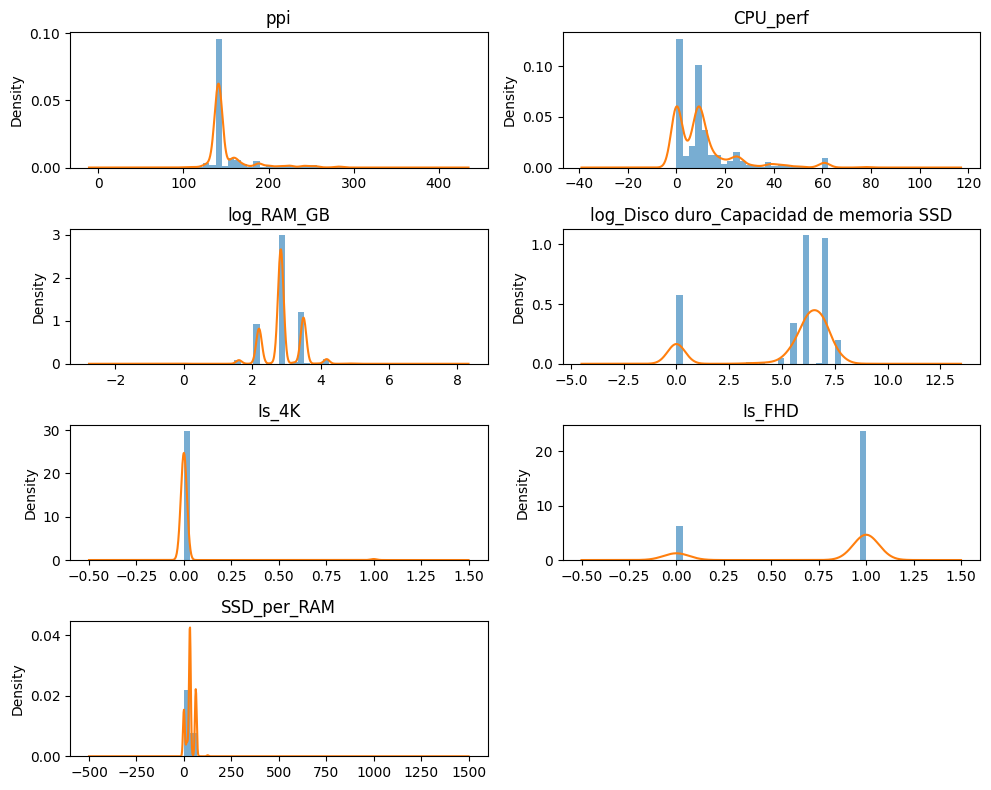

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,8))
for i, col in enumerate(new_cols, 1):
    ax = plt.subplot(4, 2, i)
    data = df_fe[col].dropna()
    ax.hist(data, bins=30, density=True, alpha=0.6)
    data.plot(kind='kde', ax=ax)
    ax.set_title(col)
plt.tight_layout()
plt.show()